### 变量理解 & 导入数据

In [57]:
import numpy as np
import pandas as pd
import math as ma
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.model_selection import ShuffleSplit
from sklearn.metrics import r2_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.datasets import load_boston
plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus']=False
# 因为显示中文为乱码所以加上上面代码

In [58]:
boston = load_boston()
features = pd.DataFrame(boston.data, columns=boston.feature_names)
target = pd.DataFrame(boston.target, columns=['MEDV'])

# data.info()
# CHAS为分类变量需要类型转换
features.CHAS = features.CHAS.astype('object')
data = pd.concat([features, target], axis=1)

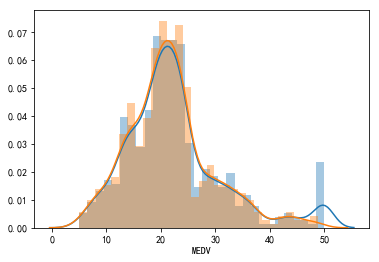

In [59]:
# data.shape
# data.isnull().sum()/data.shape[0]

# (506, 14) 数据集有506行13个特征一个目标变量"MEDV"
# 数据集不含有缺失值

sns.distplot(data.MEDV, bins=30)
# 在房屋估价的最右端等于50的数据造成了双峰分布，会对后续建模的准确性造成影响，所以不会将这一部分值放入模型中
MEDV_50 = data.iloc[data[(data.MEDV == 50)].index]
# MEDV_50

data.drop(index=data[(data.MEDV == 50)].index, inplace=True)
sns.distplot(data.MEDV, bins=30)
# 处理后数据
# data.shape :(490, 14) 数据集有506行13个特征一个目标变量"MEDV"

### 数据切分

In [60]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data[boston.feature_names], data['MEDV'],test_size=0.2,random_state=305 )

train_data = pd.concat([X_train, y_train], axis=1)

### 数据分析

In [61]:
X_train.describe()

,CRIM,ZN,INDUS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
count,392.000000,392.000000,392.000000,392.000000,392.000000,392.000000,392.000000,392.000000,392.000000,392.000000,392.000000,392.000000
mean,3.841000,10.853316,11.268546,0.557101,6.252508,68.985459,3.749907,9.706633,413.321429,18.497959,352.062781,13.084184
std,9.198642,22.561188,6.805117,0.117333,0.676530,28.081569,2.018905,8.821803,170.282521,2.153424,97.907985,7.118724
min,0.006320,0.000000,0.740000,0.385000,3.561000,2.900000,1.137000,1.000000,188.000000,12.600000,0.320000,1.980000
25%,0.083545,0.000000,5.190000,0.449000,5.878750,45.075000,2.106075,4.000000,279.750000,17.400000,374.650000,7.437500
50%,0.273975,0.000000,9.795000,0.538000,6.189000,78.050000,3.107300,5.000000,336.000000,19.100000,391.600000,12.020000
75%,3.840055,12.500000,18.100000,0.625750,6.593500,94.300000,5.116700,24.000000,666.000000,20.200000,396.900000,17.225000
max,88.976200,100.000000,27.740000,0.871000,8.780000,100.000000,10.710300,24.000000,711.000000,22.000000,396.900000,37.970000


Text(0.5,0,'房屋估价 单位:1000美金')

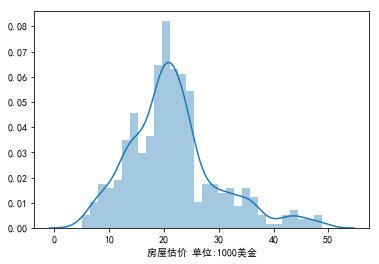

In [62]:
sns.distplot(y_train, bins=30)
# 数据基本成正态分布

plt.xlabel("房屋估价 单位:1000美金")

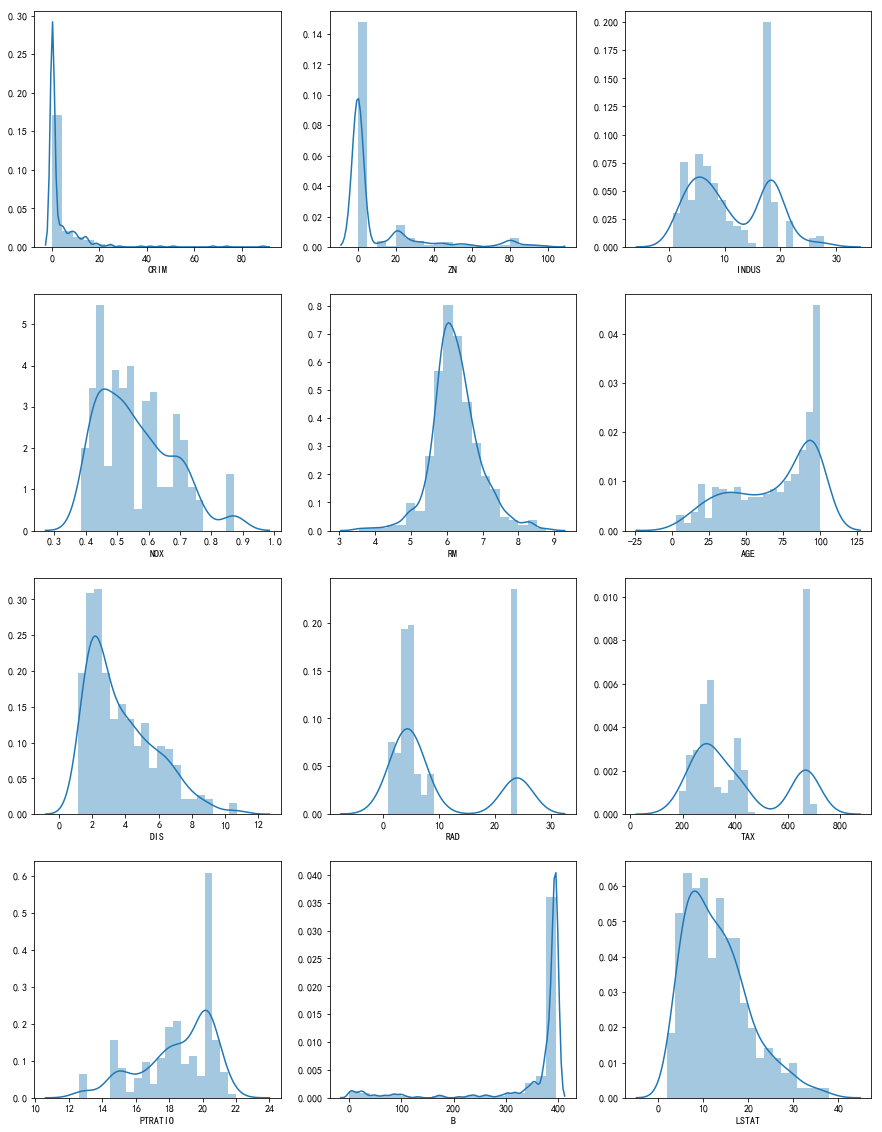

In [63]:
fnames = features.columns
cont = features.dtypes.index[features.dtypes != 'object']
r = ma.ceil(len(cont)/3)
fig, axes = plt.subplots(r,3,figsize=(15,20))
for i,j in enumerate(cont):
    a = np.repeat([i for i in range(r)],3)
    b = [j for i in range(r) for j in range(3)]
    
    sns.distplot(X_train[j], bins=20, ax=axes[a[i],b[i]])
# 除了RM变量成整体分布，其他变量多是偏态分布或双峰分布

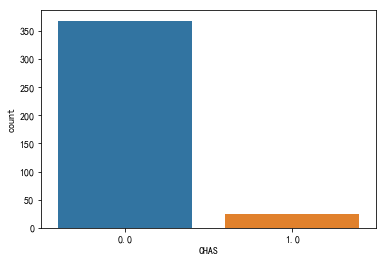

In [64]:
sns.countplot(X_train.CHAS)
# 临河房屋占比小

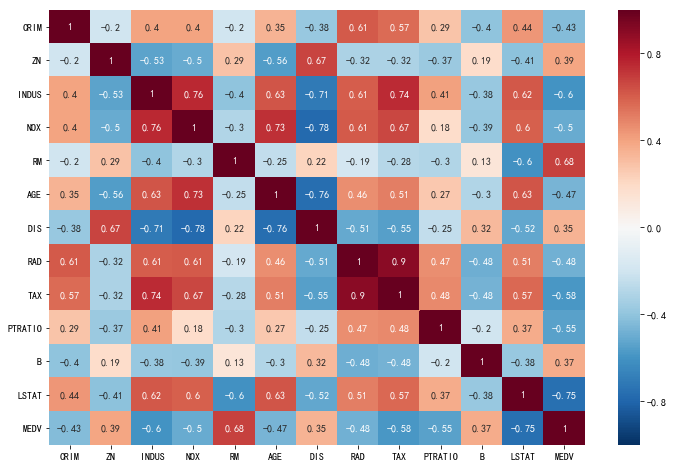

In [65]:
plt.style.use({'figure.figsize':(12, 8)})
sns.heatmap(train_data.corr(), cmap="RdBu_r", annot=True, vmin=-1, vmax=1)
# 变量间相关度比较高，因此可能导致拟合出的模型有较高的标准误，使置信区间范围变大

### 建模

In [66]:
# X_train = pd.get_dummies(X_train)
X_train.head(3)

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
197,0.04666,80.0,1.52,0,0.404,7.107,36.6,7.3090,2.0,329.0,12.6,354.31,8.61
192,0.08664,45.0,3.44,0,0.437,7.178,26.3,6.4798,5.0,398.0,15.2,390.49,2.87
209,0.43571,0.0,10.59,1,0.489,5.344,100.0,3.8750,4.0,277.0,18.6,396.90,23.09


In [67]:
""" 复杂度曲线：定义模型复杂度函数画出在不同深度下回归树在训练集和验证集上的表现，目的是通过 """
def ModelComplexity(X, y):
    
    from sklearn.model_selection import validation_curve
    # 设置随机拆分次数和随机种子
    cv = ShuffleSplit(n_splits = 10, test_size = 0.2, random_state = 305)

    # 设置最大深度从 1 到 10
    max_depth = np.arange(1,11)

    # 计算训练集验证集r2得分
    train_scores, valid_scores = validation_curve(DecisionTreeRegressor(), X, y,
        param_name = "max_depth", param_range = max_depth, cv = cv, scoring = 'r2')

    # 计算均值和方差
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    valid_mean = np.mean(valid_scores, axis=1)
    valid_std = np.std(valid_scores, axis=1)

    # 画出10次拟合得分均值曲线
    plt.figure(figsize=(7, 5))
    plt.title('回归树模型复杂度曲线')
    plt.plot(max_depth, train_mean, 'o-', color = 'r', label = '训练集得分')
    plt.plot(max_depth, valid_mean, 'o-', color = 'g', label = '验证集得分')
    
    # 增加区间估计
    plt.fill_between(max_depth, train_mean - train_std,
                     train_mean + train_std, alpha = 0.15, color = 'r')
    plt.fill_between(max_depth, valid_mean - valid_std,
                     valid_mean + valid_std, alpha = 0.15, color = 'g')
    
    plt.legend(loc = 'lower right')
    plt.xlabel('最大深度')
    plt.ylabel('r2判定系数')
    plt.ylim([-0.05,1.05])
    plt.show()
    

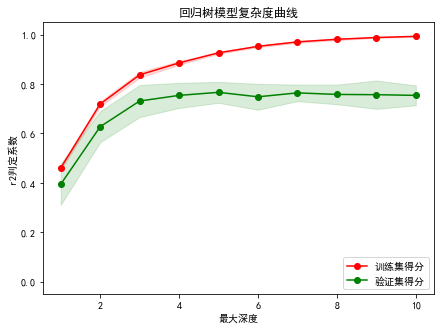

In [68]:
ModelComplexity(X_train, y_train)
# 下图表示对训练集与验证集的r2值随着最大深度的增加而拉大差距，表示模型出现过拟合的现象，最大深度为3时模型
# 为了提高模型可解释度，因此采用对特征进行选择的方法，然后从新拟合模型

### 特征选择

最大深度为3的回归树得到测试集r2_sore = 0.722


Text(0.5,1,'特征重要性')

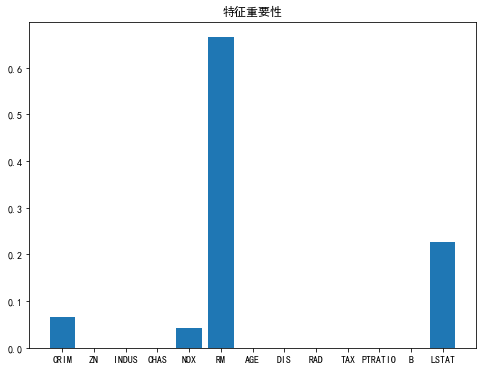

In [69]:
rt = DecisionTreeRegressor(max_depth=3, random_state=305)
t1 =  rt.fit(X_train, y_train)
pred_rt = rt.predict(X_test)
r2_score(pred_rt, y_test)
print('最大深度为3的回归树得到测试集r2_sore = {:.3f}'.format(r2_score(pred_rt, y_test)))
plt.style.use({'figure.figsize':(8, 6)})
plt.bar(X_train.columns, t1.feature_importances_)
plt.title("特征重要性")

# 找到对预测房价最重要的几个预测变量分别是RM, LSTAT, CRIM, NOX
# 明显看出RM对于房屋估价起决定性作用
# 接下来通过可视化的方式展示回归树是怎样划分数据及最后确定房屋价格的

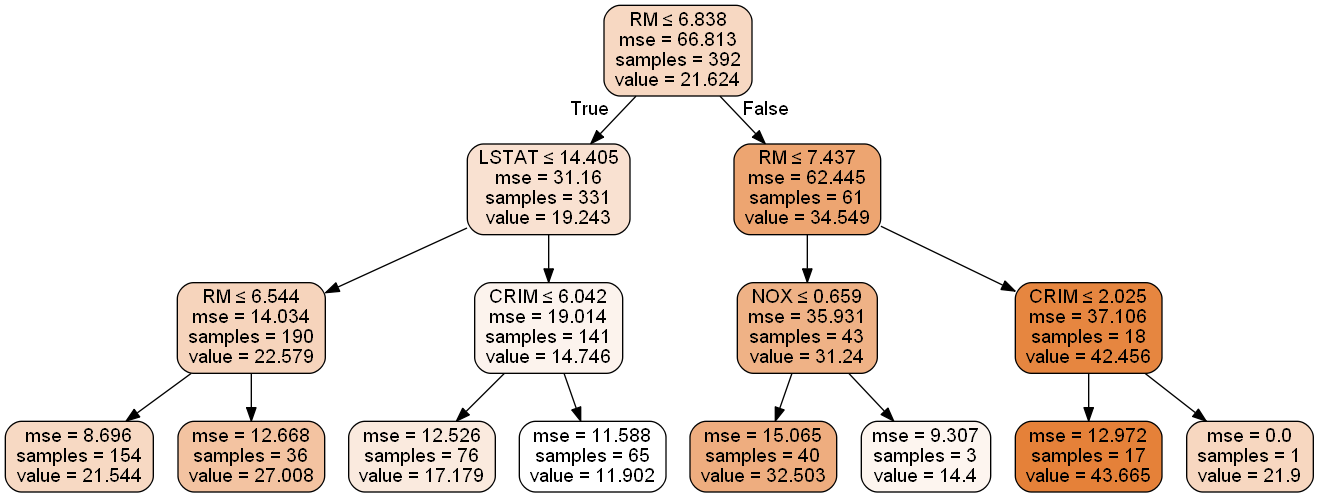

In [70]:
# import os
# os.environ["PATH"] += os.pathsep + r'D:\softwares\anaconda3\Library\bin\graphviz'

from sklearn.externals.six import StringIO
from sklearn.tree import export_graphviz
from IPython.display import Image
import pydotplus
dot_data = export_graphviz(t1, out_file=None, 
                           feature_names=X_train.columns,  
                           class_names='MEDV',  
                           filled=True, rounded=True,  
                           special_characters=True)  
graph = pydotplus.graph_from_dot_data(dot_data)
Image(graph.create_png())
# 可视化回归树路径，可以看到回归树将数据分成8组，可以看到右侧平均房屋估计最高的两组也是均方误差mse最大的两组
# 可以看出模型对估价较高的房产的预测能力较弱，一方面是对比其他组数据量较小，另一方面则可能是离群点数据所致

### 采用其他算法对模型进行拟合

In [71]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV

# 10次随机交叉验证法
cv_sets = ShuffleSplit(n_splits=10, test_size=0.20, random_state=305)

# 设置梯度提升树的固定参数
gbr = GradientBoostingRegressor(learning_rate=0.1, random_state=305)

# 设置调整的最大深度和树的总数
params = {'max_depth':[1, 2, 3],
          'n_estimators':range(20,81,20)}

grid = GridSearchCV(estimator=gbr, param_grid=params, scoring='r2', cv=cv_sets, return_train_score=True)
grid = grid.fit(X_train, y_train)
results = pd.DataFrame(grid.cv_results_)

In [72]:
print(grid.best_params_, grid.best_score_)

{'max_depth': 3, 'n_estimators': 80} 0.8694025560212738


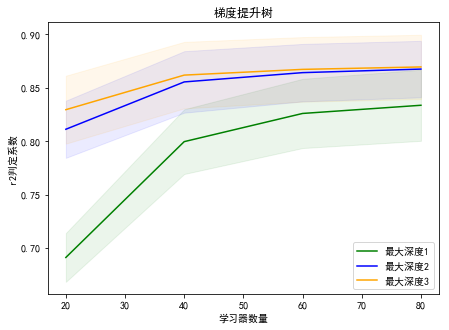

In [73]:
# 画出10次拟合得分均值曲线
plt.figure(figsize=(7, 5))
plt.title('梯度提升树')

depth1 = results[results.param_max_depth == 1]
depth2 = results[results.param_max_depth == 2]
depth3 = results[results.param_max_depth == 3]

plt.plot("param_n_estimators", "mean_test_score", color = 'green', label = '最大深度1', data=depth1)
plt.plot("param_n_estimators", "mean_test_score", color = 'blue', label = '最大深度2', data=depth2)
plt.plot("param_n_estimators", "mean_test_score", color = 'orange', label = '最大深度3', data=depth3)
    
# 增加区间估计
plt.fill_between((depth1.param_n_estimators).tolist(), 
                 (depth1.mean_test_score - depth1.std_test_score).tolist(),
                 (depth1.mean_test_score + depth1.std_test_score).tolist(), 
                 data=depth1, alpha = 0.08, color = 'green')
plt.fill_between((depth2.param_n_estimators).tolist(), 
                 (depth2.mean_test_score - depth2.std_test_score).tolist(),
                 (depth2.mean_test_score + depth2.std_test_score).tolist(), 
                 data=depth2, alpha = 0.08, color = 'blue')
plt.fill_between((depth3.param_n_estimators).tolist(), 
                 (depth3.mean_test_score - depth3.std_test_score).tolist(),
                 (depth3.mean_test_score + depth3.std_test_score).tolist(), 
                 data=depth3, alpha = 0.08, color = 'orange')

plt.legend(loc = 'lower right')
plt.xlabel('学习器数量')
plt.ylabel('r2判定系数')
plt.show()

In [74]:
# 可以看到上图显示提升树在不同最大深度(1,2,3)下在不同数目树下r2的取值
# 最大深度在2,3时的模型r2明显好于最大深度为1的模型，同时学习器数量在超过40以后r2提升不明显且误差范围稳定
# 所以会在最大深度为2,3的模型中选择学习器数量超过40的误差范围最小的模型作为最终模型
# 最后确定模型参数，最大深度为2，学习器数量为80

results[['param_max_depth', 'param_n_estimators', 'mean_test_score', 'std_test_score']]

,param_max_depth,param_n_estimators,mean_test_score,std_test_score
0,1,20,0.691082,0.022836
1,1,40,0.799495,0.030285
2,1,60,0.825864,0.032387
3,1,80,0.833525,0.033287
4,2,20,0.811070,0.026775
5,2,40,0.855371,0.028784
6,2,60,0.864065,0.026894
7,2,80,0.867394,0.026444
8,3,20,0.829400,0.031793
9,3,40,0.861755,0.031090


In [75]:
gbr_tunned = GradientBoostingRegressor(learning_rate=0.1, max_depth=2, n_estimators=80, random_state=305)
gbr_tunned.fit(X_train, y_train)
pred = gbr_tunned.predict(X_test)
print('最大深度为2,学习器数量为80得到测试集r2_sore = {:.3f}'.format(r2_score(pred, y_test)))

最大深度为2,学习器数量为80得到测试集r2_sore = 0.849


Text(0.5,1,'特征重要性')

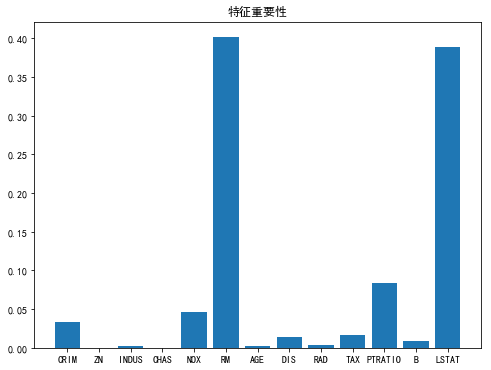

In [76]:
plt.style.use({'figure.figsize':(8, 6)})
plt.bar(X_train.columns, gbr_tunned.feature_importances_)
plt.title("特征重要性")
# 与之前决策树所得到最重要的三个特征中结果不同的是CRIM变成了PTRATIO

### 结论

In [77]:
'''
* 从回归树到梯度提升树r2值从0.722提升到0.849
* 两种算法的特征重要性(Gini importance 基尼重要性)排在前三位的分别是RM, LSTAT, CRIM 和 RM, LSTAT, PTRATIO
* 决策树算法是基于单棵树，基于基尼系数对数据集进行划分
  特点是计算速度快，可以生成特征重要性，同时可解释性强，缺点是预测能力较弱，容易过拟合
* 梯度提升树是属于集成方法中提升的一类算法，个体学习器按序生成，强依赖关系
  也是基于基尼系数来对数据集进行划分
  特点是模型预测能力强，可以生成特征重要性，缺点是因为学习器众多所以计算速度较慢，同时因为众多的学习器所以模型不容易理解
'''

'\n* 从回归树到梯度提升树r2值从0.722提升到0.849\n* 两种算法的特征重要性(Gini importance 基尼重要性)排在前三位的分别是RM, LSTAT, CRIM 和 RM, LSTAT, PTRATIO\n* 决策树算法是基于单棵树，基于基尼系数对数据集进行划分\n  特点是计算速度快，可以生成特征重要性，同时可解释性强，缺点是预测能力较弱，容易过拟合\n* 梯度提升树是属于集成方法中提升的一类算法，个体学习器按序生成，强依赖关系\n  也是基于基尼系数来对数据集进行划分\n  特点是模型预测能力强，可以生成特征重要性，缺点是因为学习器众多所以计算速度较慢，同时因为众多的学习器所以模型不容易理解\n'